In [173]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time

In [174]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import cos, sin

In [175]:
from scipy.linalg import solve    
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve 

### Parameters

In [176]:
# Number of steps
N = 10

# mu
mu = 0.01

In [177]:
# Velocity field

def v1(x, y):
    return y
    
def v2(x, y):
    return -x

### Respective functions

In [178]:
#test function
def u(x, y):
    return sin(x)*sin(y)

#insert test function into diffusion equation
def f(x, y):
    return 1

#Dirchlet boundary conditions:
# y = 1
def g_n(x):
    return 0
    
# y = 0
def g_s(x):
    return 0

# x = 0
def g_w(y):
    return 0

# x = 1
def g_e(y):
    return 0
    

### Build Diagonal Matrix

In [179]:
def A_and_b(h, mu, Ni, Ni2, N, x, y,):
    
    # Inner points
    xi = x[1:-1]       
    yi = y[1:-1] 
    Xi, Yi = np.meshgrid(xi, yi)
    X, Y = np.meshgrid(x, y)
    
    V1 = v1(Xi, Yi)
    V2 = v2(Xi, Yi)
    
    # Coefficients
    a_p = (4 * mu) / h**2
    a_e = (- mu/h**2 + V1/(2*h)).flatten()
    a_n = (- mu/h**2 + V2/(2*h)).flatten()
    a_w = (- mu/h**2 - V1/(2*h)).flatten()
    a_s = (- mu/h**2 - V2/(2*h)).flatten()
    
    
    # Add diagonals
    diag = a_p * np.ones(Ni2)
    A = np.diag(diag)
    
    diag1 = np.arange(Ni2-1)
    A[diag1, diag1+1] = a_e[0:Ni2-1]
    A[diag1+1, diag1] = a_w[1:Ni2]
    
    diag2 = np.arange(Ni2-Ni)
    A[diag2, diag2+Ni] = a_n[0:Ni2-Ni]
    A[diag2+Ni, diag2] = a_s[Ni:Ni2]
    
    
    # Fill inn b vector
    b = np.zeros(Ni2)
    for j in range(Ni):
        for i in range(Ni):
            b[j*Ni + i] = f(xi[i], yi[j])
    
    V2_s = v2(X[0,1:-1], Y[0, 1:-1])
    V1_w = v1(X[1:-1,0], Y[1:-1, 0])
    V2_n = v2(X[N,1:-1], Y[N, 1:-1])
    V1_e = v1(X[1:-1,N], Y[1:-1, N])
    
    
    # Coefficients edges
    a_e_edge = (- mu/h**2 + V1_e/(2*h)).flatten()
    a_n_edge = (- mu/h**2 + V2_n/(2*h)).flatten()
    a_w_edge = (- mu/h**2 - V1_w/(2*h)).flatten()
    a_s_edge = (- mu/h**2 - V2_s/(2*h)).flatten()
    
    
    # Include the boundary conditions
    b[0:Ni] = b[0:Ni] - a_s_edge*g_s(xi)                        # y=0
    b[Ni2-Ni:Ni2] = b[Ni2-Ni:Ni2] - a_n_edge*g_n(xi)            # y=1
    b[0:Ni2:Ni] = b[0:Ni2:Ni] - a_w_edge*g_w(yi)                # x=0
    b[Ni-1:Ni2:Ni] = b[Ni-1:Ni2:Ni] - a_e_edge*g_e(yi)          # x=1
    
    
    return A, b

### Solver Function

In [180]:
def pde_solve(N,mu):
    
    
    # Time run
    start = time.time()
    
    
    # Step size
    h = 1/N
    
    
    # Make grid
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1) 
    X, Y = np.meshgrid(x, y)
    Ni = N-1       # Number of inner points in each direction
    Ni2 = Ni**2    # Number of inner points in total
    
    
    # Exact Solution
    #U_exact = u(X, Y)
    
    
    # Create A matrix
    A, b = A_and_b(h, mu, Ni, Ni2, N, x, y)
    
    
    # Handle interior stack-edges
    for i in range(1, Ni):
        edge = i*Ni
        A[edge-1, edge] = 0
        A[edge, edge-1] = 0
    
    
    # Use sparce matrix format
    A = sparse.csr_matrix(A)
    A = A.tocsr()
    
    
    # Solve system numerically
    U = spsolve(A, b)
    U = np.reshape(U, (Ni, Ni))
    
    
    # Add edges to solution
    U = np.pad(U, pad_width=1, mode='constant', constant_values=0)
    U[0, :] = g_s(x)
    U[N, :] = g_n(x)
    U[:, 0] = g_w(y)
    U[:, N] = g_e(y)
    
    #error = np.max(np.max(abs(U-U_exact)))
    
    
    #Print the error
    #print(f'The steplength is {1}/{N}. The error is: {error}. Runtime total: {time.time()-start}')
    
    return U, X, Y, h

### Solutions

In [181]:
U, X, Y, h = pde_solve(100, mu)
U1, X1, Y1, h1 = pde_solve(10,mu)

### Plot Results

<IPython.core.display.Javascript object>


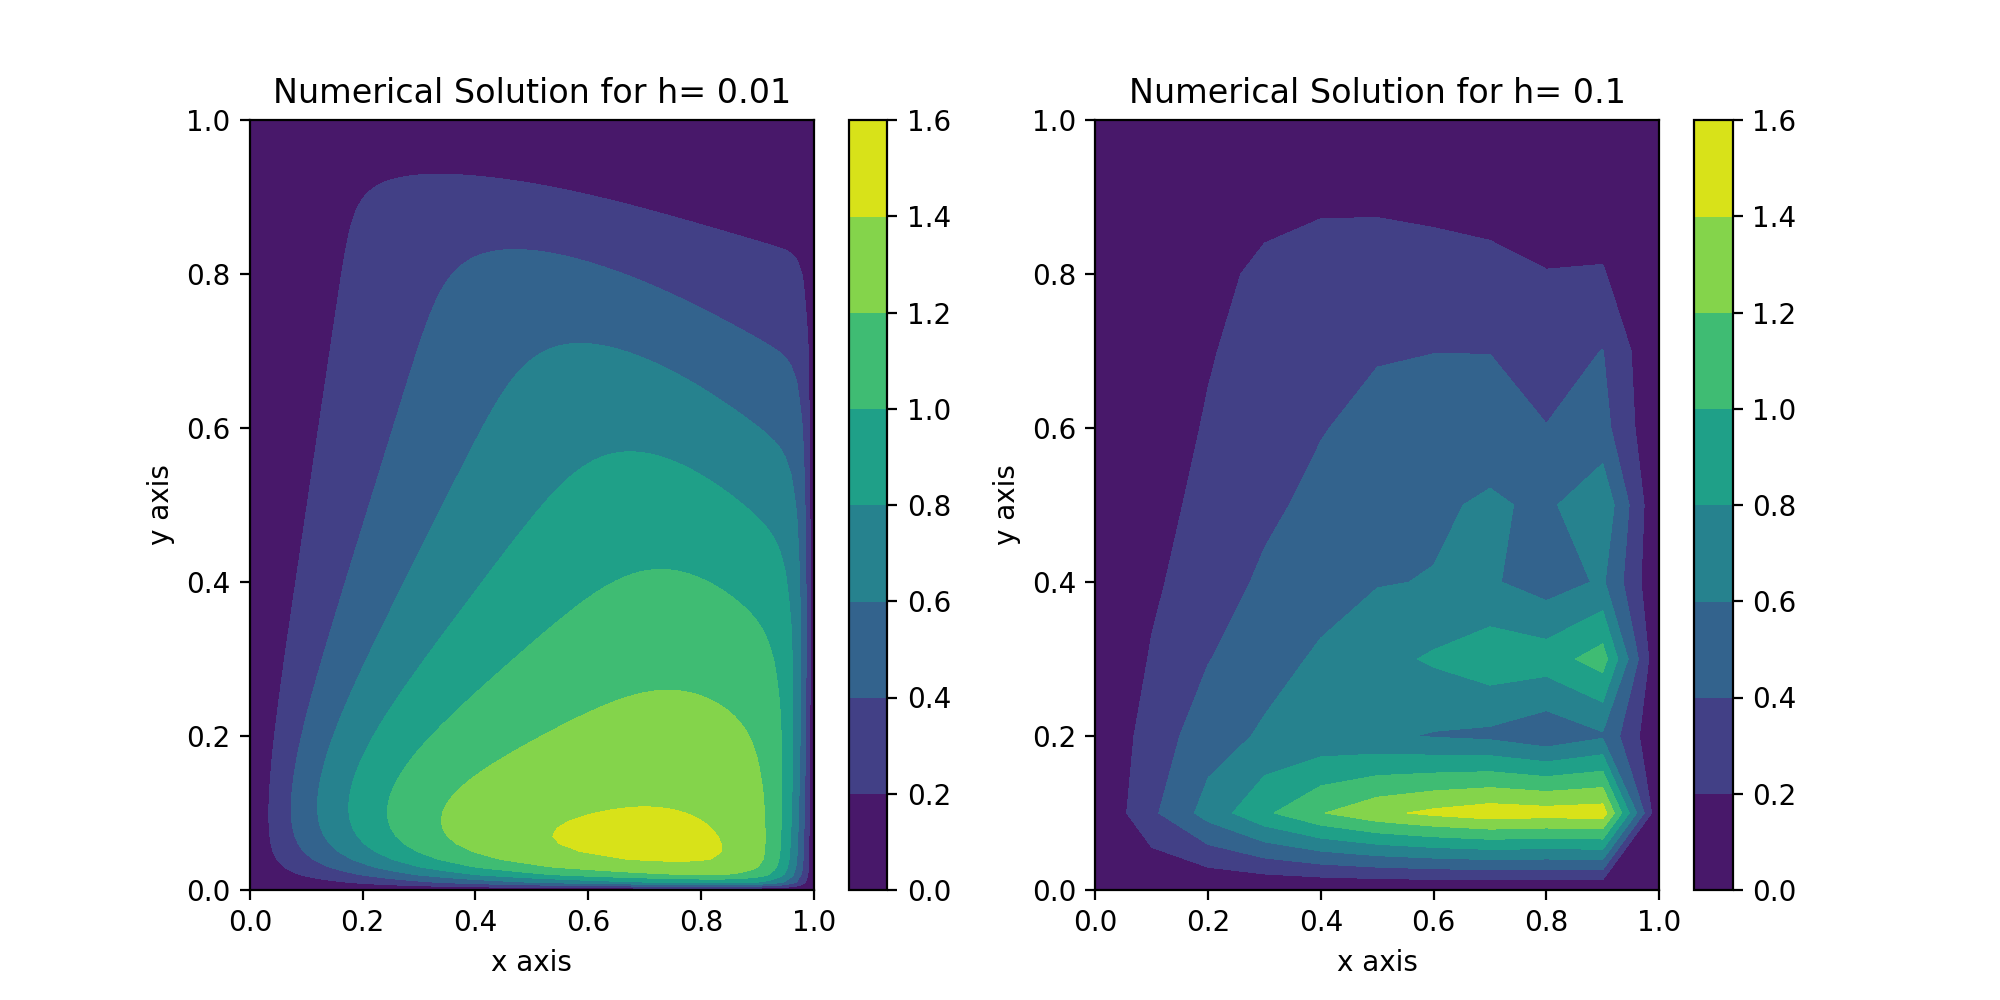

In [190]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#subplot 1
cf = ax1.contourf(X, Y, U)
ax1.title.set_text('Numerical Solution for h= '+str(h))
ax1.set_ylabel('y axis')
ax1.set_xlabel('x axis')


#subplot 2
cf2 = ax2.contourf(X1, Y1, U1)
ax2.title.set_text('Numerical Solution for h= ' + str(h1))
ax2.set_ylabel('y axis')
ax2.set_xlabel('x axis')


fig.colorbar(cf, ax=ax1)
fig.colorbar(cf, ax=ax2)

<IPython.core.display.Javascript object>


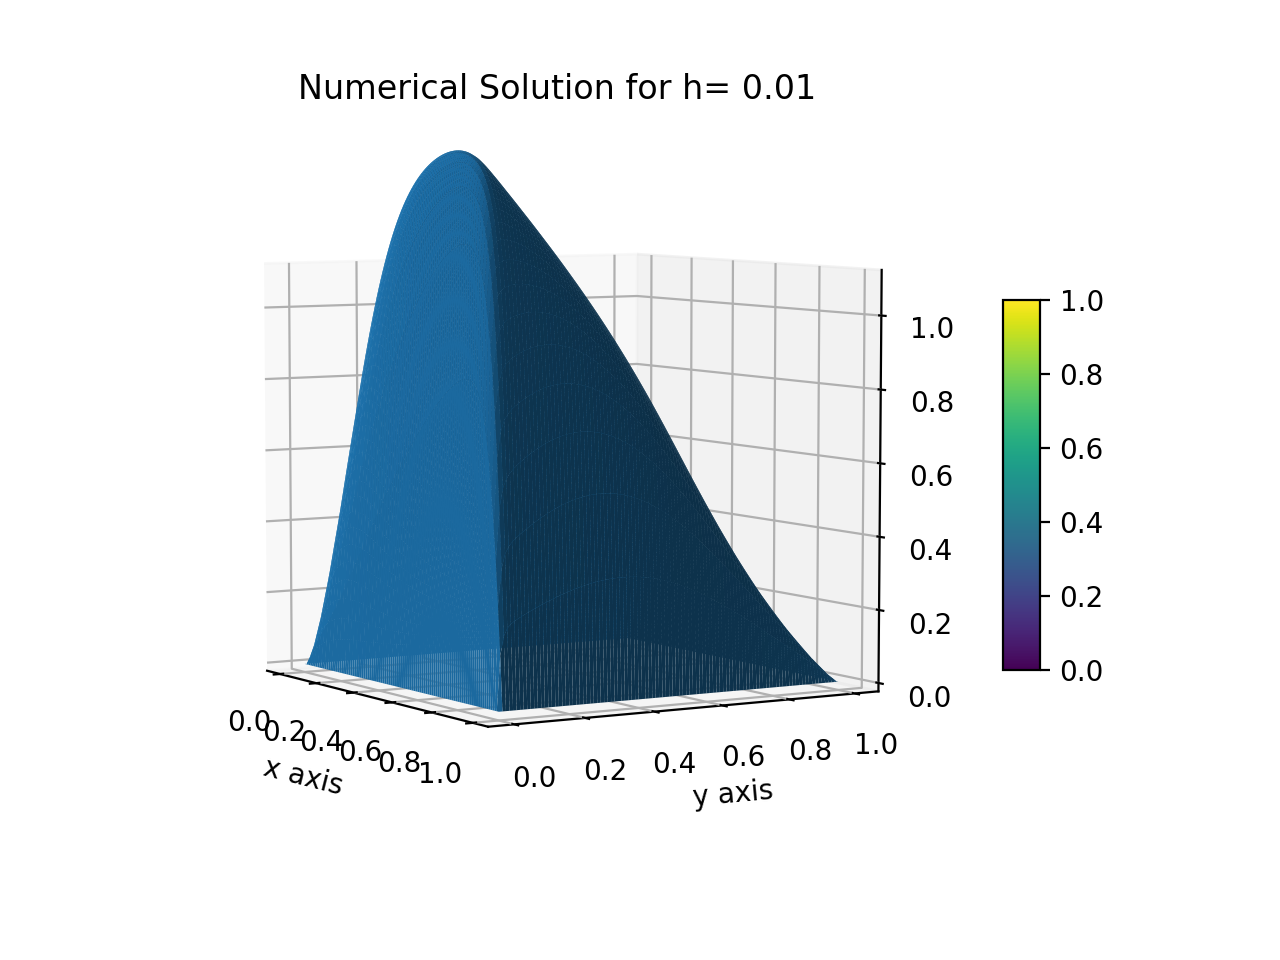

<IPython.core.display.Javascript object>


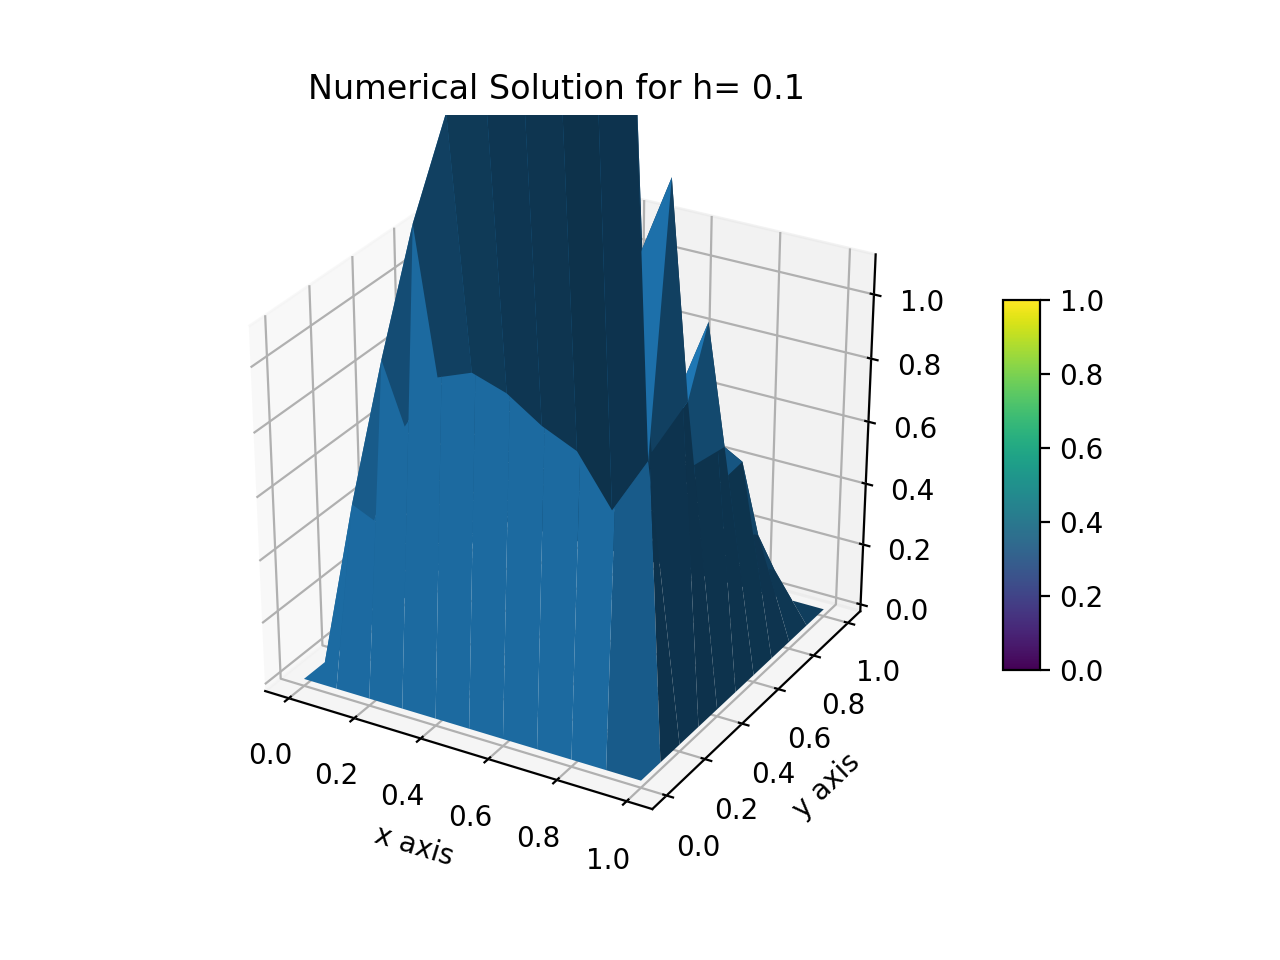

In [192]:
%matplotlib notebook

#3D plot
fig3d= plt.figure()
ax = fig3d.gca(projection='3d')

#First plot
surf = ax.plot_surface(X, Y, U, rstride=1, cstride=1)
ax.set_zlim(0,1.1)
ax.title.set_text('Numerical Solution for h= '+ str(h))
ax.set_ylabel('y axis')
ax.set_xlabel('x axis')
fig3d.colorbar(surf, shrink=0.5, aspect=10)
                             
#Second plot
fig3d2= plt.figure()
ax2 = fig3d2.gca(projection='3d')
surf2 = ax2.plot_surface(X1, Y1, U1, rstride=1, cstride=1)
ax2.set_zlim(0,1.1)
ax2.title.set_text('Numerical Solution for h= '+ str(h1))
ax2.set_ylabel('y axis')
ax2.set_xlabel('x axis')
fig3d2.colorbar(surf2, shrink=0.5,aspect = 10)

plt.show()
                
                             
#fig= plt.figure()
#ax2 = fig.add_subplot(111, projection='3d')
#ax1.plot_surface(X1, Y1, U1)